**Step 1: Import all the libraries required**

In [14]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

**Step 2: Initialize Pose Detection Model**

In [15]:
# Initialize mediapipe pose class
mp_pose = mp.solutions.pose

# Setting up the pose function
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initialize mediapipe drawing class, useful for annotation
mp_drawing = mp.solutions.drawing_utils

**Read an Image**

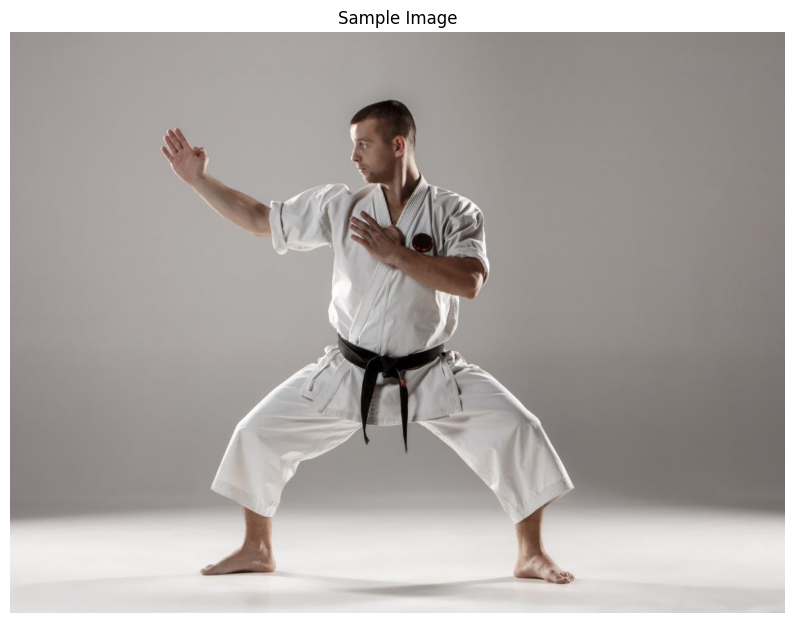

In [16]:
# Read an image
sample_img = cv2.imread('karate.jpg')

# Set the size of the figure
plt.figure(figsize=[10, 10])

# Display the sample image, also convert BGR to RGB for display
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:, :, ::-1]);plt.show()

**Perform Pose Detection (Image)**

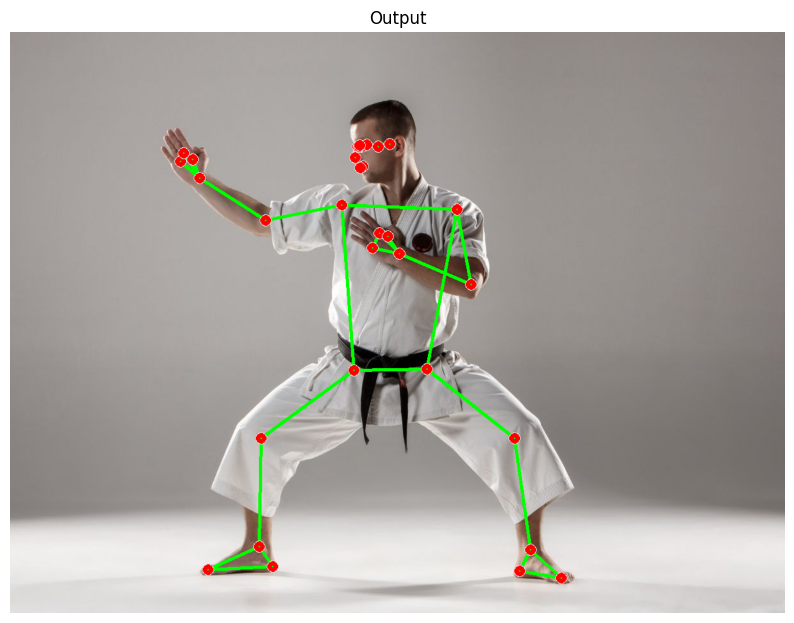

In [17]:
# Perform pose detection after converting image to RGB format
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Copy of the sample image
img_copy = sample_img.copy()

# Check if landmarks are found
if results.pose_landmarks:

    # Define custom styles
    landmark_style = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=5, circle_radius=5)  # Red color for landmarks
    connection_style = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=4)  # Green color, thicker connections

    # Draw landmarks and connections on the sample image with custom styles
    mp_drawing.draw_landmarks(
        image=img_copy,
        landmark_list=results.pose_landmarks,
        connections=mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=landmark_style,
        connection_drawing_spec=connection_style
    )

    # Set the size of the figure
    plt.figure(figsize=[10, 10])

    # Display the sample image, also convert BGR to RGB for display
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:, :, ::-1]);plt.show()

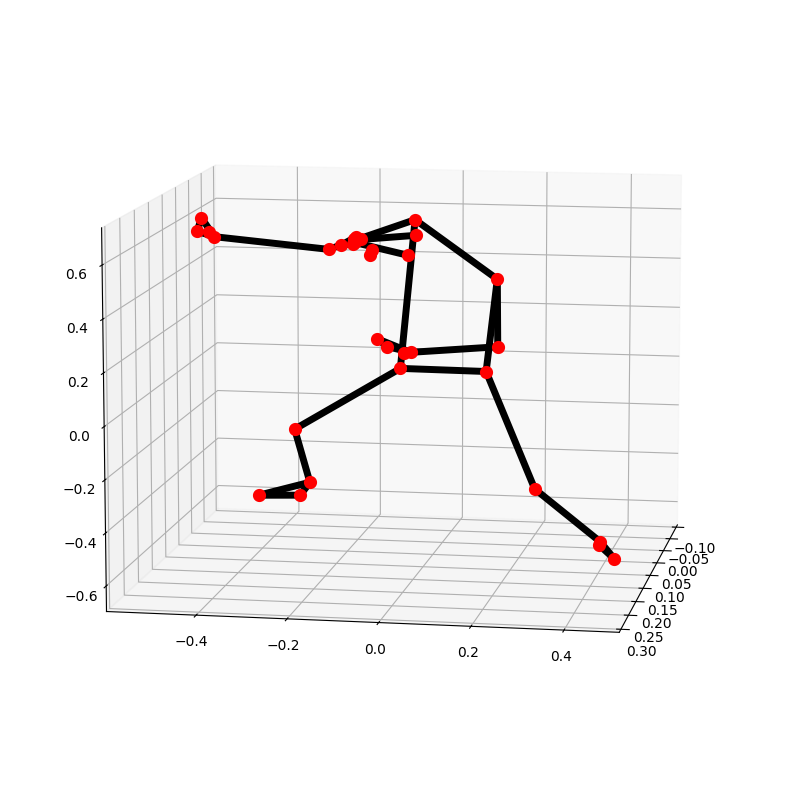

In [18]:
# Plot Pose Landmark in 3D
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

**Step 3: detectPose Function**

In [19]:
def detectPose(image, pose, display=True):
    '''
    Detects and displays pose landmarks on an image.

    Args:
        image: The input image to process.
        pose: The MediaPipe pose model used for detection.
        display: If True, shows the original and annotated images with a 3D plot of landmarks.
                 If False, returns the annotated image and landmarks.

    Returns:
        output_image: The image with drawn pose landmarks (if display is False).
        landmarks: A list of (x, y, z) coordinates of detected landmarks (if display is False).

    Example:
        output_image, landmarks = detectPose(image, pose, display=False)
    '''

    # Create a copy of the image
    output_image = image.copy()

    # Convert the image from BGR to RGB format
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the pose detection
    results = pose.process(imageRGB)

    # Retrieve the height and width of the image
    height, width, _ = image.shape

    # Initialize a list to store the landmarks
    landmarks = []

    # Check if any landmarks are detected
    if results.pose_landmarks:

        # Define custom styles
        landmark_style = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=5, circle_radius=5)  # Red for landmarks
        connection_style = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=4)  # Green for connections

        # Draw landmarks and connections on output_image with custom styles
        mp_drawing.draw_landmarks(
            image=output_image,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=landmark_style,
            connection_drawing_spec=connection_style
        )

        # Append detected landmarks to the list
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x * width), int(landmark.y * height), int(landmark.z * width)))

    # Display images if specified
    if display:
        plt.figure(figsize=[21, 21])
        plt.subplot(121); plt.axis('off'); plt.imshow(image[:, :, ::-1]); plt.title("Original Image")
        plt.subplot(122); plt.axis('off'); plt.imshow(output_image[:, :, ::-1]); plt.title("Output Image")
        
        # Plot 3D landmarks
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    
    # Return output image and landmarks if display is False
    else:
        return output_image, landmarks


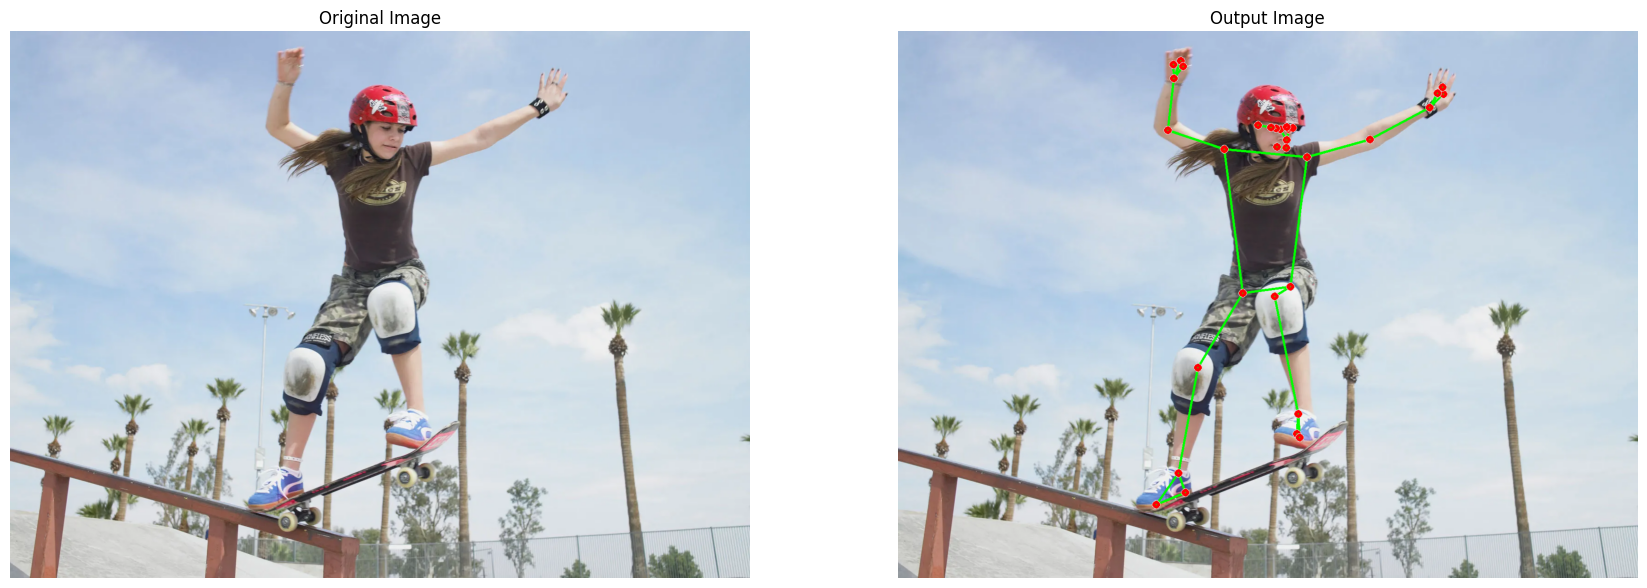

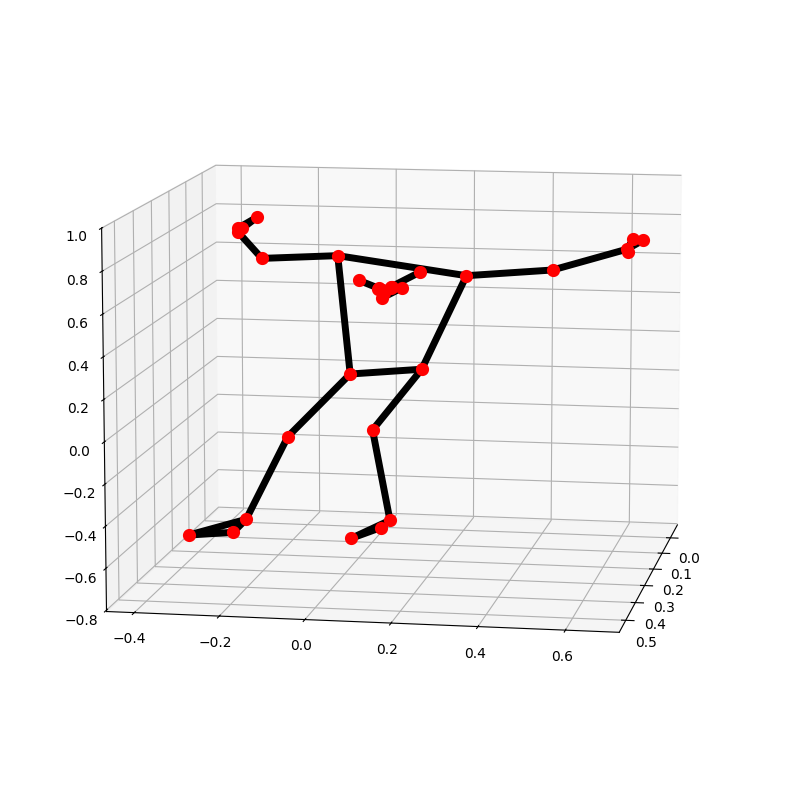

In [20]:
# Setting up the pose function
image = cv2.imread('skateboard.jpg')
detectPose(image=image, pose=pose, display=True)

**Pose Detection on Video**

In [21]:
# Setup Pose Function for video
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize Video
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

# Create window name
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)

# Set video camera size
cap.set(3, 640)
cap.set(4, 480)

# Initialize a variable to store the time of the previous frame
time1 = 0

# Loop for Video
while cap.isOpened():

    # Read a frame
    ret, frame = cap.read()

    # Break the loop if video is not open
    if not ret:
        break

    # Get the width and height of the frame
    frame_height, frame_width, _ = frame.shape

    # Resize the frame while keeping the aspect ratio
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640)) 

    # Perform Pose Landmark Detection
    frame, _ = detectPose(frame, pose_video, display=False)

    # Set the time for this frame to the current time
    time2 = time()

    # Check if the difference between the previous and this frame time > 0 to avoid division by zero
    if (time2 - time1) > 0:

        # Calculate the number of frame per second
        frames_per_second = 1.0 / (time2 - time1)

        # Write the calculated number of frames per second on the frame
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

    # Previous frame = Current frame
    time1 = time2

    # Display the frame
    cv2.imshow('Pose Detection', frame)

    # Wait until 'q' key is pressed
    k = cv2.waitKey(1) & 0xFF

    # Check if 'ESC' is pressed
    if(k == 27):
        break

# Release camera
cap.release()

# Close all window
cv2.destroyAllWindows()
